<a href="https://colab.research.google.com/github/jeffmcm1977/CMBAnalysis_SummerSchool/blob/master/CMB_School_Part_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lensing simulation tutorial

Here we will simulate *CMB lensing*, the process by which the *paths of CMB photons are deflected by large-scale structure as they traverse the Universe.*
 (Image source: ESA/Planck)

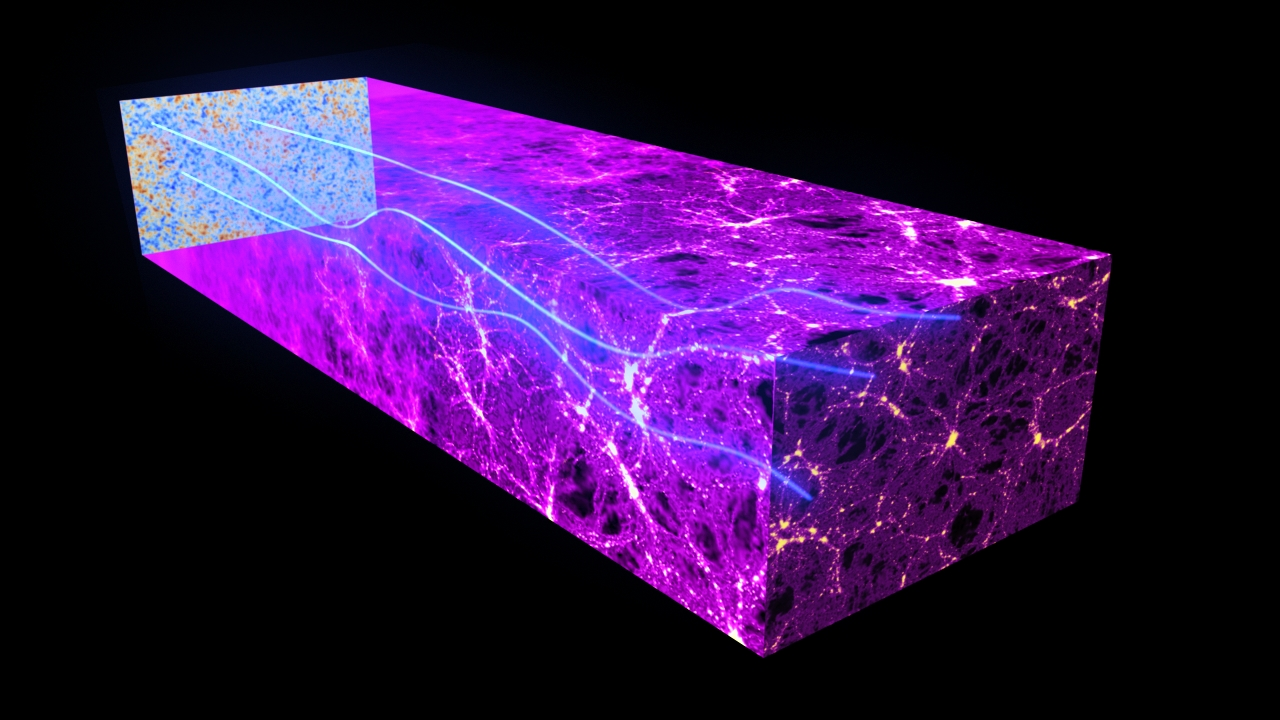


The unlensed CMB temperature $\tilde T(\mathbf n)$ at angular position $\mathbf n$ is a Gaussian field, which we have seen how to simulate.

The action of lensing is that we see the CMB evaluated at a *deflected position* $$T^\mathrm{len}(\mathbf n) = \tilde T(\mathbf n + \mathbf d(\mathbf n)).$$

The deflection is (to good approximation) given as the *gradient of a scalar,* $$\mathbf d(\mathbf n)= \nabla \phi(\mathbf n),$$ where $\phi$ is known as the **CMB lensing potential**.  This two-dimensional field is the line-of-sight projection of the 3d gravitational potential from all the strctures in the Universe between us and the CMB.

$\phi$ is (to good approximation) a Gaussian field, and its power spectrum $C_\ell^{\phi\phi}$ is computed by codes like CAMB.  Let's load up the CMB temperature and potential power spectra, and make a simulation of them both.

In [ ]:
!python -c "import cmb_modules" || ( \
    wget https://github.com/jeffmcm1977/CMBAnalysis_SummerSchool/raw/master/cmb_school.tar.gz && \
    tar xzvf cmb_school.tar.gz \
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# We use some stuff we learned before
import cmb_modules
np.random.seed(100)

### Simulating an unlensed map



In [ ]:
patch_deg_width = 40. # patch width in degrees
pix_size = 1.5 # pixel size in arcminutes

# Number of pixels in each direction
N = int(patch_deg_width*60./pix_size)

# We need to load the theory spectra
def get_theory():
    ells,tt,_,_,pp,_ = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat",unpack=True)
    TCMB2 = 7.4311e12
    ckk = pp/4./TCMB2
    ucltt = tt / ells/(ells+1.)*2.*np.pi
    ells2,lcltt = np.loadtxt("CMB_fiducial_totalCls.dat",unpack=True,usecols=[0,1])
    lcltt = lcltt / ells2/(ells2+1.)*2.*np.pi
    lcltt = lcltt[:len(ells)]
    return ells,ucltt,lcltt,ckk


ells,ucltt,lcltt,clkk = get_theory()

# We next generate an unlensed CMB map as a Gaussian random field as we learned before
DlTT = ucltt*ells*(ells+1.)/2./np.pi
unlensed = cmb_modules.make_CMB_T_map(N,pix_size,ells,DlTT)

## variables to set up the map plots
c_min = -400  # minimum for color bar
c_max = 400   # maximum for color bar
X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees


print('Unlensed CMB')
cmb_modules.Plot_CMB_Map(unlensed,c_min,c_max,X_width,Y_width)


Sometimes we work with the **CMB lensing convergence** $\kappa(\mathbf n)$, a projection of the matter density.  The potential and convergence are related by a Poisson equation, $$\kappa(\mathbf n) = -\nabla^2 \phi(\mathbf n)/2,$$ or in Fourier space, $$\kappa(\ell) = \dfrac{\ell(\ell+1)}{2} \, \phi(\ell)$$

Let's make a simulation of $\kappa(\mathbf n)$ -- a projection of the (dark) matter between us and the CMB:

In [ ]:
# We need a lensing convergence (kappa) map
DlKK = clkk*ells*(ells+1.)/2./np.pi
kappa = cmb_modules.make_CMB_T_map(N,pix_size,ells,DlKK)
plt.imshow(kappa)
plt.colorbar()
plt.title('CMB lensing convergence $\kappa$')
plt.show()

To simulate the **deflection** action of lensing, we will obtain our $\phi$ map from this $\kappa$ map; evaluate $\nabla \phi$; and determine the shifted positions for the CMB, $\mathbf n + \nabla \phi(\mathbf n).$  We will do the actual position interpolation using the `scipy.ndimage.map_coordinates`.

In [ ]:
def lens_map(imap,kappa,modlmap,ly,lx,N,pix_size):
    # 1. We convert lensing convergence to lensing potential
    phi = kappa_to_phi(kappa,modlmap,return_fphi=True)

    # 2. We take its gradient to get the deflection field
    grad_phi = gradient(phi,ly,lx)

    # 3. We calculate the displaced positions by
    # shifting the (pixels converted to) physical positions by the deflections
    pos = posmap(N,pix_size) + grad_phi

    # 4. Convert physical positions to pixel space (fractional displaced pixel indices)
    # because scipy doesn't know about physical distances
    pix = sky2pix(pos, N,pix_size)

    # 4.5. We prepare an empty output lensed map array
    omap = np.empty(imap.shape, dtype= imap.dtype)

    # 5. Use scipy to calculate the values of the input lensed map
    #    at the displaced (fractional) positions by interpolation
    #    and grid that onto the final lensed map
    from scipy.ndimage import map_coordinates
    map_coordinates(imap, pix, omap, order=5, mode='wrap')
    return omap

# This function needs to know about the Fourier coordinates of the map
# returns ells in y-direction, ells in x-direction, and ells = sqrt(lx^2+ly^2)
def get_ells(N, pix_size):
    # This function returns Fourier wavenumbers for a Cartesian square grid
    N = int(N)
    ones = np.ones(N)
    inds = (np.arange(N) + .5 - N/2.) / (N-1.) # ranges from -0.5 to 0.5 for
                                               # Fourier conventions
    ell_scale_factor = 2. * np.pi
    lx = np.outer(ones,inds) / (pix_size/60. * np.pi/180.) * ell_scale_factor
    ly = np.transpose(lx)
    modlmap = np.sqrt(lx**2. + ly**2.)
    return ly,lx,modlmap

# STEP 1:
# We need to convert kappa to phi
def kappa_to_phi(kappa,modlmap,return_fphi=False):
    # mask out the monopole + dipole first
    return filter_map(kappa,kmask(2./modlmap/(modlmap+1.),modlmap,ellmin=2))

# where we used a Fourier space masking function which will come in handy
def kmask(filter2d,modlmap,ellmin=None,ellmax=None):
    # Apply a minimum and maximum multipole mask to a filter
    if ellmin is not None: filter2d[modlmap<ellmin] = 0
    if ellmax is not None: filter2d[modlmap>ellmax] = 0
    return filter2d

# To do that we also need to know generally how to filter
# a real space map with a 2D Fourier space filter
def filter_map(Map,filter2d):
    FMap = np.fft.fftshift(np.fft.fft2(Map))
    FMap_filtered = FMap * filter2d
    Map_filtered = np.real(np.fft.ifft2(np.fft.ifftshift(FMap_filtered)))
    return Map_filtered

# STEP 2:
# We also need to calculate a gradient, easier in Fourier space
def gradient(imap,ly,lx):
    # Filter the map by (i ly, i lx) to get gradient
    return np.stack([filter_map(imap,ly*1j),filter_map(imap,lx*1j)])

# STEP 3:
# We also needed the map of physical positions
def posmap(N,pix_size):
    pix    = np.mgrid[:N,:N]
    return pix2sky(pix,N,pix_size)

# For that we need to be able to convert pixel indices to sky positions
def pix2sky(pix,N,pix_size):
    py,px = pix
    dec = np.deg2rad((py - N//2 - 0.5)*pix_size/60.)
    ra = np.deg2rad((px - N//2 - 0.5)*pix_size/60.)
    return np.stack([dec,ra])

# STEP 4:
# Finally, for the lensing operation, we also needed to convert physical
# sky positions to pixel indices which is just the inverse of the above
def sky2pix(pos,N,pix_size):
    dec,ra = np.rad2deg(pos)*60.
    py = dec/pix_size + N//2 + 0.5
    px = ra/pix_size + N//2 + 0.5
    return np.stack([py,px])

# We get the Fourier coordinates
ly,lx,modlmap = get_ells(N,pix_size)

# Now we can lens our input unlensed map
lensed = lens_map(unlensed,kappa,modlmap,ly,lx,N,pix_size)

print('Lensed CMB')
cmb_modules.Plot_CMB_Map(lensed,c_min,c_max,X_width,Y_width)


In [ ]:
print('Lensed minus unlensed CMB')
cmb_modules.Plot_CMB_Map(lensed - unlensed,c_min/5,c_max/5,X_width,Y_width) #increase image contrast by a factor of 5



What happens if we take our lensed map and convolve it with a beam + add noise?

In [ ]:
#Convolving with a beam and adding noise

# Beam
beam_arcmin = 1.4
def gauss_beam(ell,fwhm):
    # A gaussian beam transfer function (map-space, i.e. one power)
    tht_fwhm = np.deg2rad(fwhm / 60.)
    return np.exp(-(tht_fwhm**2.)*(ell**2.) / (16.*np.log(2.)))
# Evaluate the beam on an isotropic Fourier grid
kbeam2d = gauss_beam(modlmap,beam_arcmin)
# Filter the map to convolve it with a beam
beamed = filter_map(lensed,kbeam2d)

# Noise
noise_uk_arcmin = 1.5 # CMB-S4 level white noise
# White noise
Clnoise = (noise_uk_arcmin*np.pi/180./60.)**2.
Dlnoise = Clnoise*ells*(ells+1.)/2./np.pi
# Make a GRF noise map
noise_map = cmb_modules.make_CMB_T_map(N,pix_size,ells,Dlnoise)

# The observed map
observed = beamed + noise_map

print('Observed CMB')
cmb_modules.Plot_CMB_Map(observed,c_min,c_max,X_width,Y_width)


<font color='red'>EXERCISE: </font> Compare the power spectrum of the lensed CMB map (no beam, no noise) with the unlensed CMB map (no beam, no noise). Can you clearly see what features lensing induces? If it's too noisy, you could try Monte Carloing multiple realizations and averaging over them?